📥 Upload your 'medical_full_realistic_1000.csv' and model.pkl...


Saving medical_full_realistic_1000.csv to medical_full_realistic_1000 (7).csv
📥 Upload a patient report (CSV, PDF, or Image)...


Saving VITAMIN-E-TOCOPHEROL-Test-Abnormal-Result-report-format-example-sample-template-Drlogy-lab-report.pdf to VITAMIN-E-TOCOPHEROL-Test-Abnormal-Result-report-format-example-sample-template-Drlogy-lab-report (3).pdf

✅ Detected Condition: Hyperlipidemia
🔹 Confidence: 12.00%
📊 Full Prediction Probabilities:
 - Anemia: 2.67%
 - Arthritis: 6.00%
 - Asthma: 8.67%
 - COPD: 4.67%
 - Cancer: 8.00%
 - Chronic Kidney Disease: 4.67%
 - Diabetes: 4.67%
 - Gout: 6.00%
 - Heart Disease: 5.33%
 - Hyperlipidemia: 12.00%
 - Hypertension: 6.67%
 - Hyperthyroidism: 1.33%
 - Hypothyroidism: 1.33%
 - Infection: 6.67%
 - Liver Disease: 2.67%
 - Malaria: 2.67%
 - Pneumonia: 4.67%
 - Sepsis: 3.33%
 - Stroke: 4.67%
 - Tuberculosis: 3.33%


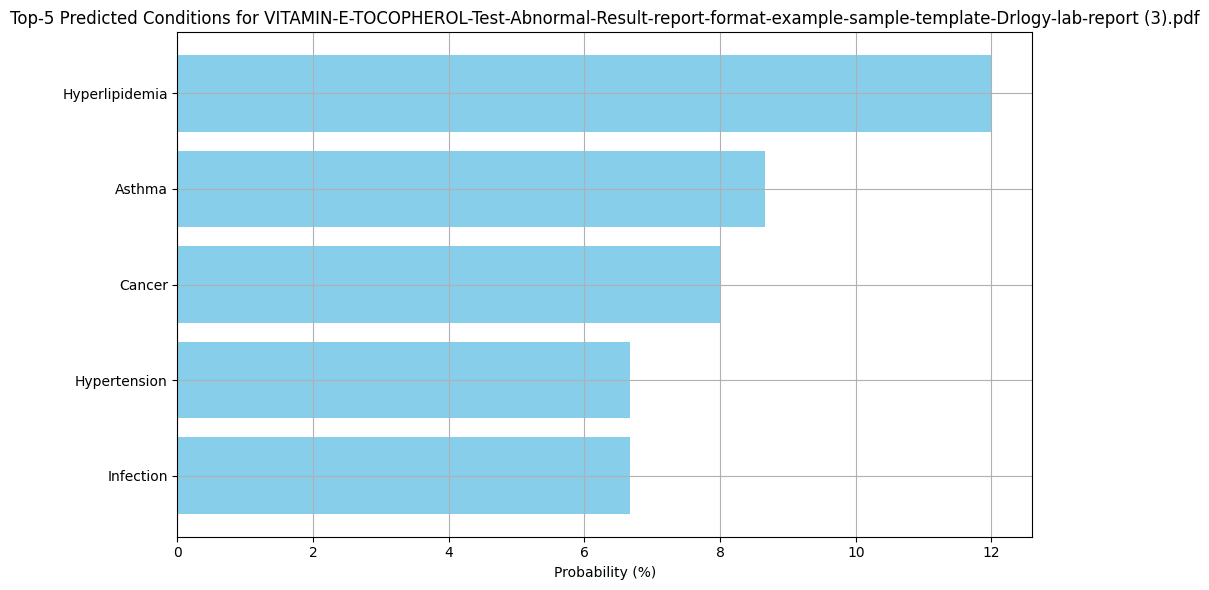

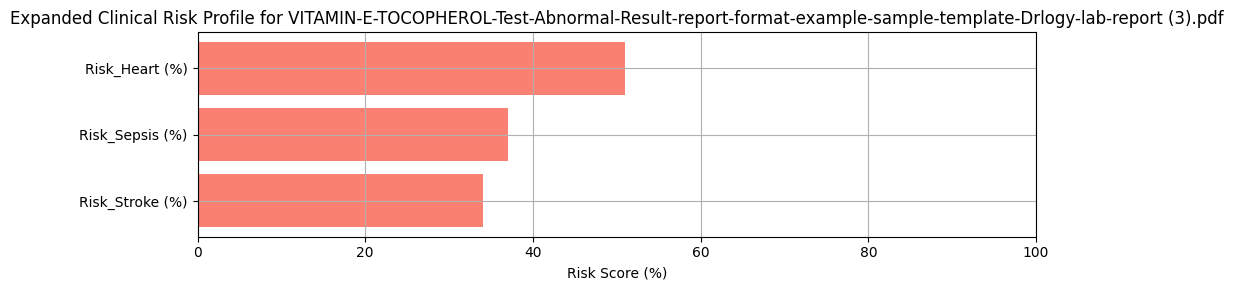

In [15]:
# -------------------------------------------
# Install Required Libraries
# -------------------------------------------
!pip install -q pandas numpy scikit-learn matplotlib joblib pdfplumber pytesseract

# -------------------------------------------
# Import Libraries
# -------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from google.colab import files
import pdfplumber
import pytesseract
from PIL import Image
import io
import re

# -------------------------------------------
# Upload and Load Dataset
# -------------------------------------------
print("📥 Upload your 'medical_full_realistic_1000.csv' and model.pkl...")
uploaded = files.upload()

for filename in uploaded.keys():
    if filename.endswith('.csv'):
        try:
            dataset = pd.read_csv(filename, encoding='utf-8')
        except:
            dataset = pd.read_csv(filename, encoding='ISO-8859-1')
    elif filename.endswith('.pkl'):
        model = joblib.load(filename)

# Dataset Preprocessing
X = dataset.drop(['Patient_ID', 'Condition', 'Recommendation', 'Medications',
                  'Doctor_Comment', 'Doctor_Advice', 'Symptoms'], axis=1)
y = dataset['Condition']
le_gender = LabelEncoder()
X['Gender'] = le_gender.fit_transform(X['Gender'])
X = X.fillna(X.median())

# -------------------------------------------
# Upload a Report to Predict
# -------------------------------------------
print("📥 Upload a patient report (CSV, PDF, or Image)...")
uploaded = files.upload()

def extract_text_from_pdf(file_path):
    with pdfplumber.open(file_path) as pdf:
        return "\n".join(page.extract_text() for page in pdf.pages if page.extract_text())

def extract_text_from_image(file_path):
    image = Image.open(file_path)
    return pytesseract.image_to_string(image)

def parse_text_to_features(text, feature_columns):
    data = {}
    for feature in feature_columns:
        if feature == 'Gender':
            data[feature] = 0 if 'Female' in text else 1
        else:
            pattern = re.compile(rf"{feature}[:\s\-]*([\d\.]+)", re.IGNORECASE)
            match = pattern.search(text)
            data[feature] = float(match.group(1)) if match else X[feature].median()
    return pd.DataFrame([data])

# -------------------------------------------
# Prediction + Dynamic Graphs
# -------------------------------------------
for fname in uploaded.keys():
    try:
        if fname.endswith('.csv'):
            patient_df = pd.read_csv(fname, encoding='latin1')
            patient_df['Gender'] = le_gender.transform(patient_df['Gender'])
            patient_df = patient_df.fillna(X.median())

        elif fname.endswith('.pdf'):
            text = extract_text_from_pdf(fname)
            patient_df = parse_text_to_features(text, X.columns)

        elif fname.endswith(('.png', '.jpg', '.jpeg')):
            text = extract_text_from_image(fname)
            patient_df = parse_text_to_features(text, X.columns)

        else:
            print(f"❌ Unsupported file: {fname}")
            continue

        # Prediction
        prediction = model.predict(patient_df)[0]
        proba = model.predict_proba(patient_df)[0]
        class_labels = model.classes_

        print(f"\n✅ Detected Condition: {prediction}")
        print(f"🔹 Confidence: {max(proba)*100:.2f}%")
        print("📊 Full Prediction Probabilities:")
        for cond, prob in zip(class_labels, proba):
            print(f" - {cond}: {prob*100:.2f}%")

        # Top-5 Condition Bar Chart
        top5 = pd.DataFrame({
            'Condition': class_labels,
            'Probability': proba * 100
        }).sort_values(by='Probability', ascending=False).head(5)

        plt.figure(figsize=(10, 6))
        plt.barh(top5['Condition'], top5['Probability'], color='skyblue')
        plt.xlabel('Probability (%)')
        plt.title(f'Top-5 Predicted Conditions for {fname}')
        plt.gca().invert_yaxis()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Dynamic Clinical Risk Plot
        details = patient_df.iloc[0]
        risk_cols = [col for col in details.index if "Risk" in col and "%" in col]
        risk_scores = {col: details[col] for col in risk_cols}

        if risk_scores:
            plt.figure(figsize=(10, max(3, len(risk_scores)*0.6)))
            plt.barh(list(risk_scores.keys()), list(risk_scores.values()), color='salmon')
            plt.xlabel('Risk Score (%)')
            plt.title(f'Expanded Clinical Risk Profile for {fname}')
            plt.xlim(0, 100)
            plt.gca().invert_yaxis()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        else:
            print("⚠️ No risk scores found for plotting.")

    except Exception as e:
        print(f"❌ Error: {e}")
